**Mount Google Drive**

Mount Google Drive to access the dataset stored in your Drive. (if you install the dataset in google drive)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Import Required Libraries**

This section imports all the necessary libraries for data processing, visualization, and building the VGG16 transfer learning model.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import glob as gb
import cv2
import tensorflow as tf
import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

**Define Dataset Path**

Here, we define the path to the dataset. You can switch between different datasets by uncommenting the appropriate line.

In [3]:
# File Path
# First dataset
#c = '/content/drive/MyDrive/Final Project/R_C_256/'

# Second dataset (commented out)
c = '/content/drive/MyDrive/Final Project/Augmented18000/'

# Third dataset (commented out)
#c = '/content/drive/MyDrive/Final Project/Augmented data-set/'

**Map Class Names to Numerical Labels**

This dictionary maps class names (Normal, Pothole, Cracks) to numerical labels (0, 1, 2).

In [4]:
code = {'Normal': 0, 'Pothole': 1, 'Cracks': 2}

# Function to get the class name from the numerical label
def get_code(n):
    for x, y in code.items():
        if n == y:
            return x

**Load Training Data**

This section loads the training images and their corresponding labels into X_train and y_train.

In [5]:
# Load Training Data
X_train = []
y_train = []
for folder in os.listdir(c + 'Training'):
    files = gb.glob(pathname=str(c + 'Training//' + folder + '/*.jpg'))
    for file in files:
        image = cv2.imread(file)
        X_train.append(image)
        y_train.append(code[folder])

**Load Testing Data**

This section loads the testing images and their corresponding labels into X_test and y_test.

In [6]:
# Load Testing Data
X_test = []
y_test = []
for folder in os.listdir(c + 'Testing'):
    files = gb.glob(pathname=str(c + 'Testing//' + folder + '/*.jpg'))
    for file in files:
        image = cv2.imread(file)
        X_test.append(image)
        y_test.append(code[folder])


**Load Validation Data**

This section loads the validation images and their corresponding labels into X_val and Y_val.

In [7]:
# Load Validation Data
X_val = []
Y_val = []
for folder in  os.listdir(c +'Validation') :
    files = gb.glob(pathname= str(c + 'Validation//' + folder + '/*.jpg'))
    for file in files:
        image = cv2.imread(file)
        X_val.append(image)
        Y_val.append(code[folder])

**Convert Lists to Numpy Arrays**

Convert the lists of images and labels into numpy arrays for compatibility with TensorFlow/Keras.

In [8]:
# Convert to numpy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)
y_train = np.array(y_train)
y_test = np.array(y_test)
Y_val = np.array(Y_val)

**Convert Labels to Categorical Format**

Convert the numerical labels to categorical format for multi-class classification.

In [9]:
# Convert labels to categorical format
y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)
Y_val = to_categorical(Y_val, num_classes=3)

# Print the shapes of the datasets
print(f'X_train shape  is {X_train.shape}')
print(f'X_test shape  is {X_test.shape}')
print(f'X_val shape  is {X_val.shape}')
print(f'y_train shape  is {y_train.shape}')
print(f'y_test shape  is {y_test.shape}')
print(f'y_val shape  is {Y_val.shape}')

X_train shape  is (13336, 256, 256, 3)
X_test shape  is (3330, 256, 256, 3)
X_val shape  is (1335, 256, 256, 3)
y_train shape  is (13336, 3)
y_test shape  is (3330, 3)
y_val shape  is (1335, 3)


**Preprocess Input for VGG16**

Preprocess the input data to match the format required by the VGG16 model.

In [10]:
# Preprocess input
X_train = tf.keras.applications.vgg16.preprocess_input(X_train)
X_test = tf.keras.applications.vgg16.preprocess_input(X_test)
X_val = tf.keras.applications.vgg16.preprocess_input(X_val)

**Load VGG16 Model**

Load the pre-trained VGG16 model with weights from ImageNet. Freeze the base model to prevent its weights from being updated during training.

In [11]:
# Load VGG16 model
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False  # Freeze the weights

**Build the Model**

Add custom layers on top of the VGG16 base model for classification.

In [12]:
# Build the model
model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [13]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

**Define Early Stopping**

Define early stopping to prevent overfitting during training.

In [14]:
# Define early stopping
early_stopping = EarlyStopping(patience=3, monitor='accuracy', restore_best_weights=True)

In [15]:
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 256, 256, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 128, 128, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 32, 32, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

**Train the Model**

Train the model using the training data and validate it using the validation data.

In [16]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_data = (X_val,Y_val), batch_size=32, callbacks=[early_stopping])


Epoch 1/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 25s 47ms/step - accuracy: 0.8692 - loss: 0.5546 - val_accuracy: 0.9730 - val_loss: 0.0711
Epoch 2/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.9804 - loss: 0.0642 - val_accuracy: 0.9768 - val_loss: 0.0805
Epoch 3/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.9903 - loss: 0.0318 - val_accuracy: 0.9805 - val_loss: 0.0795
Epoch 4/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.9918 - loss: 0.0205 - val_accuracy: 0.9820 - val_loss: 0.0646
Epoch 5/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.9979 - loss: 0.0087 - val_accuracy: 0.9655 - val_loss: 0.1519
Epoch 6/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.9947 - loss: 0.0178 - val_accuracy: 0.9753 - val_loss: 0.0856
Epoch 7/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.9878 - loss: 0.0538 - val_accuracy: 0.9783 - val_loss: 0.0784


**Evaluate the Model**

Evaluate the model's performance on the test dataset and print the accuracy and loss.

In [17]:
# Evaluate the model
loss,accuracy= model.evaluate(X_test, y_test)
print('Test accuracy: {:2.2f}%'.format(accuracy*100))
print('Test loss {:2.2f}%'.format(loss*100))

105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9961 - loss: 0.0124
Test accuracy: 99.07%
Test loss 3.17%


In [18]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

**Plot Training and Validation Loss**

Visualize the training and validation loss over epochs.

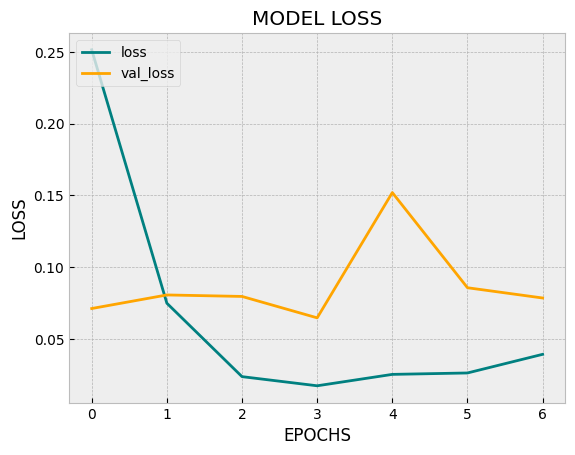

In [19]:
# Plot training and validation loss
plt.style.use('bmh')
fig=plt.figure()
plt.plot(history.history['loss'],color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
plt.title('MODEL LOSS')
plt.xlabel('EPOCHS')
plt.ylabel('LOSS')
plt.legend(loc='upper left')
plt.show()

**Plot Training and Validation Accuracy**

Visualize the training and validation accuracy over epochs.

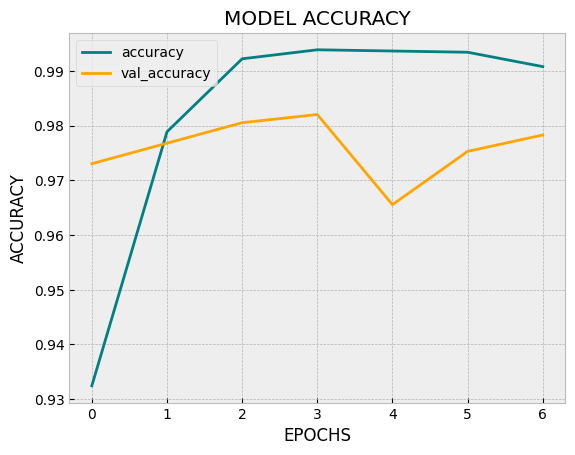

In [20]:
# Plot training and validation accuracy
plt.style.use('bmh')
fig=plt.figure()
plt.plot(history.history['accuracy'],color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
plt.title('MODEL ACCURACY')
plt.xlabel('EPOCHS')
plt.ylabel('ACCURACY')
plt.legend(loc='upper left')
plt.show()

**Confusion Matrix**

Compute and plot the confusion matrix to evaluate the model's performance.

105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step


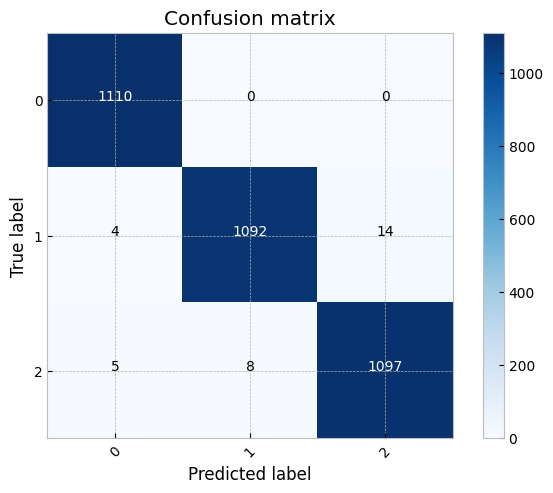

In [21]:
# Function to plot the confusion matrix
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis=1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test, axis=1)  # Convert y_test to class labels

# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes=range(3))

**Classification Report**

Print the classification report to evaluate precision, recall, and F1-score.

In [22]:
# Print the classification report
from sklearn.metrics import classification_report
print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1110
           1       0.99      0.98      0.99      1110
           2       0.99      0.99      0.99      1110

    accuracy                           0.99      3330
   macro avg       0.99      0.99      0.99      3330
weighted avg       0.99      0.99      0.99      3330

